<h1><center><strong>PRACTICA Nº1</strong></center></h1>
<p><strong>Name</strong> : Julia<p>  
<h4><strong>Aims:</strong></h4>
<ol>
    <li>Obtener la serie temporal de lluvia de un punto geográfico.</li>
    <li>Presentar un mapa con la ubicación del punto seleccionado</li>
    <li>Calcular las medidas de estadística descriptiva.</li>
    <li>Obtener la Climatología.</li>
    <li>Representar gráficamente.</li>
    <li>Justificar la elección de la base de datos TRMM o PISCO para el punto escogido.</li>
    <li>Redactar describiendo los resultados obtenidos.</li>
</ol> 

In [530]:
%%capture
#======================================
# Importing Libraries 
#======================================
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import cmocean as cmo
from rasterio import features
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
from cartopy.io.shapereader import Reader
from shapely.geometry.polygon import LinearRing
from affine import Affine
import mplleaflet
import seaborn as sns
import string
import eofs
import os
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [554]:
#---------------------------
# Reading datasets 
#---------------------------
fili_nc = './DATASETS/new_PISCO2.nc'
fili_pkl = '/media/carlos/DATA/MERH_TRABAJO/STATISTICAL_METHODS_PROJECT/DATASET/SENAMHI_month_v1.0'
ds_pisco = xr.open_dataset(fili_nc, decode_cf=False)
ds_pisco = xr.decode_cf(ds_pisco)
df_senamhi = pd.read_pickle(fili_pkl)
#---------------------------
# Select stations
#---------------------------
station_name = 'ABANCAY'
df_station = df_senamhi[df_senamhi.index.get_level_values('Station_Name') == station_name]
df_station = df_station.reset_index()
#df_station = df_station.set_index('Date')
gdf_station = gpd.GeoDataFrame(df_station[['Lat','Lon','Lev','PP','Depart','Date']], 
                               geometry=gpd.points_from_xy(df_station.Lon, df_station.Lat))

<h4><strong>Sol:</strong></h4>
<ol>
    <li>Obtener la serie temporal de lluvia de un punto geográfico.</li>
</ol>

In [460]:
#------------------------
# Setting coordinates
#------------------------
lats,lons = [df_station.Lat[0], df_station.Lon[0]]
ds_point = ds.sel(lat=lats,lon=lons, method='nearest')

In [461]:
def plot_station_xy(ds, labels, mean=False, std=False):
    font = {'family':'serif', 'color':'grey', 'weight':'normal', 'size':13}
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(12,5), dpi=100)
    labels='Pisco estación latitude={:.2f} y longitud={:.2f}'.format(ds_point.P.lat.values,ds_point.P.lon.values)
    ds.plot(ax=ax, linewidth=.8, label=labels)
    if mean==True:
        ax.axhline(y=mean.P.values, linewidth=.8, color='m', linestyle='--', label='Mean = {:.2f}'.format(mean.P.values))
        ax.axhline(y=std.P.values, linewidth=.8, color='green', linestyle='--', label='Std={:.2f}'.format(std.P.values))
    dates_rng = pd.date_range('1980-01-01','2018-12-01', freq='24M')
    plt.xticks(dates_rng, [dtz.strftime('%Y-%m') for dtz in dates_rng], rotation=30, size=8)
    ax.set_title('Serie Temporal de Lluvia', fontdict=font)
    ax.set_ylabel('Precipitación (mm/mes)')
    ax.set_xlabel('')
    ax.legend(loc='upper right',prop={'size': 10},ncol=3)
    ax.grid(linestyle='--')
    ax.set_xlim([datetime.date(1980, 6, 1), datetime.date(2017, 6, 1)])

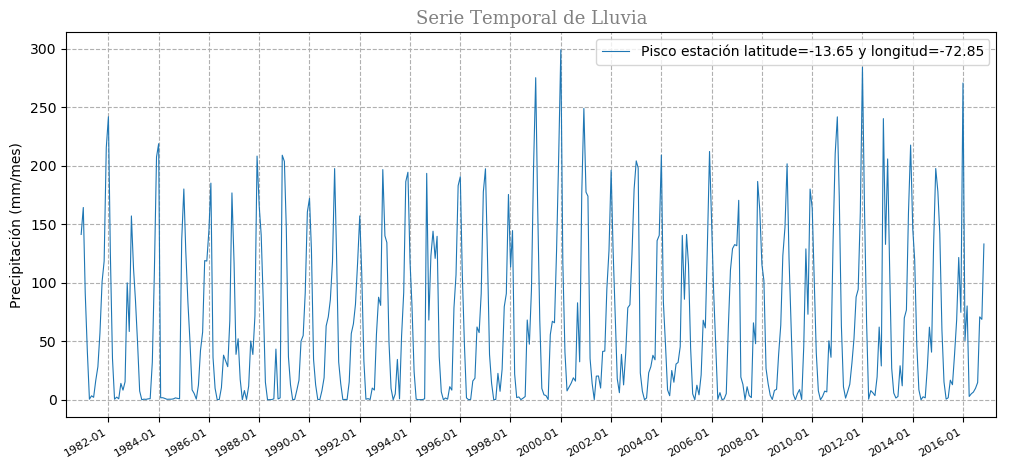

In [462]:
plot_station_xy(ds_point.P, labels='Datos Pisco')

<h4><strong>Sol:</strong></h4>
<ol start="2">
    <li>Presentar un mapa con la ubicación del punto seleccionado.</li>
</ol>

In [463]:
def plot_stations_loc(ds, gdf, proj=ccrs.PlateCarree(), cmp=cmo.cm.rain):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10,10), dpi=80, subplot_kw=dict(projection=proj))
    font = {'family':'serif', 'color':'grey', 'weight':'normal', 'size':13}
    lon_formatter =  LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.set_extent([ds.lon[0].values, ds.lon[-1].values, ds.lat[0].values, ds.lat[-1].values])
    border_features = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_countries', 
                                                   scale='10m',facecolor='none',edgecolor='grey', 
                                                   linewidth=0.4)
    pls = ds.P.isel(time=120).plot.contourf(ax=ax, add_colorbar=False, levels=40, cmap=cmp, 
                                            transform=ccrs.PlateCarree(), zorder=0)
    ax.set_xticks(np.arange(-82,-70,4), crs=proj)
    ax.set_yticks(np.arange(-16, 0,4), crs=proj)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(border_features,zorder=1)
    ax.set_extent([-82, -70, -16, 0], crs= proj)
    ax.add_feature(cfeature.LAKES, zorder=2)
    ax.add_feature(cfeature.RIVERS, zorder=3)
    ax.scatter(gdf.Lon, gdf.Lat, transform=ccrs.PlateCarree(), zorder=5, s=20.6, color='m', marker='D')
    ax.grid(linestyle='--',color='gray',alpha=0.5)
    ax.set_title('Ubicación de Estación', fontdict=font)
    fig.colorbar(pls, label='Pisco Precipitación (mm/month)')

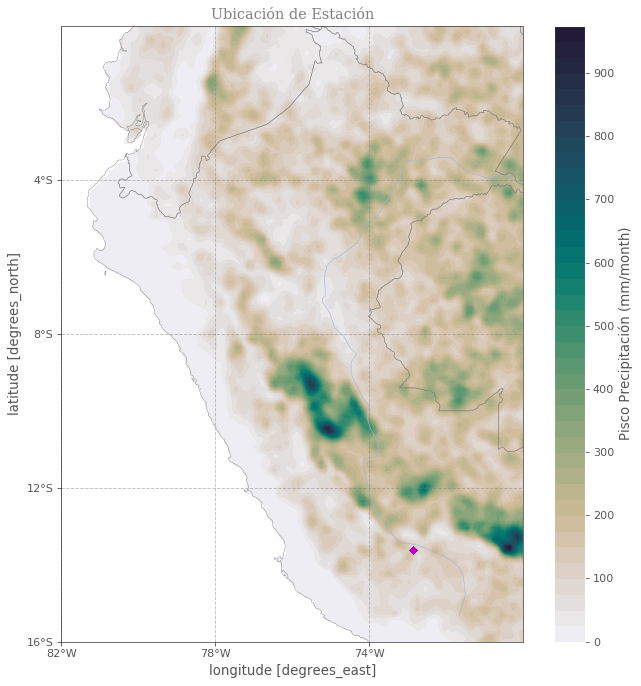

In [464]:
plot_stations_loc(ds_pisco, gdf_station)

<h4><strong>Sol:</strong></h4>
<ol start=3>
    <li>Calcular las medidas de estadística descriptiva.</li>
</ol> 

In [465]:
[mean, std] = [ds_point.mean(), ds_point.std()]

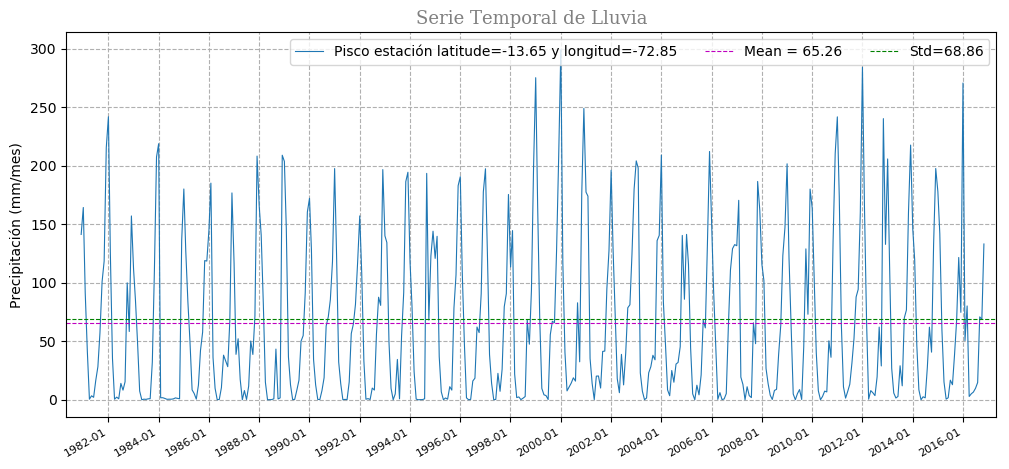

In [466]:
plot_station_xy(ds_point.P, labels='Datos Pisco', mean=mean, std=std)

<h4><strong>Sol:</strong></h4>
<ol start=4>
    <li>Obtener la Climatología.</li>
</ol> 

In [467]:
ds_point_climo = ds_point.groupby('time.month').mean('time', skipna=True)

In [471]:
def climo_plot(ds):
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(10,6), dpi=100)
    font = {'family':'serif', 'color':'grey', 'weight':'normal', 'size':13}
    labels='Pisco - Estación: latitude={:.2f} y longitud={:.2f}'.format(ds.P.lat.values,ds.P.lon.values)
    plt.bar(np.arange(1,13), ds.P)
    dates_rng = [dtz.strftime('%B') for dtz in pd.date_range('1980-01-01','1980-12-01', freq='1M')]
    #dates_rng = [datetime.date(2008, i, 1).strftime('%B') for i in np.arange(1,13)]
    ax.set_title('Serie Temporal '+ labels, fontdict=font)
    ax.set_ylabel('Precipitación (mm/mes)')
    ax.set_xlabel('')
    ax.grid(linestyle='--')
    plt.xticks(np.arange(1,13), [x[:3] for x in dates_rng], rotation=30, size=8)    

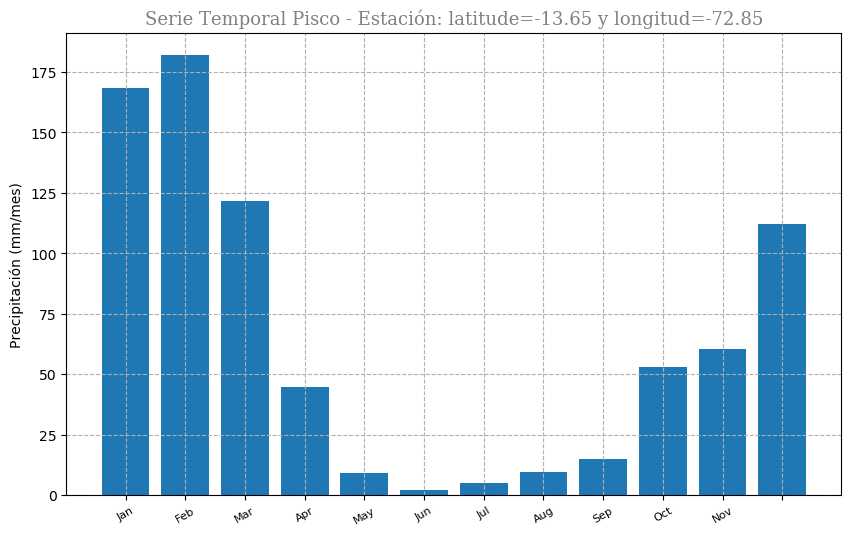

In [472]:
climo_plot(ds_point_climo)

In [548]:
df_station_prec = df_station[['PP','Date']]
df_station_monthly = df_station_prec.resample('M', on='Date').sum()
df_pisco = ds_point.to_dataframe()

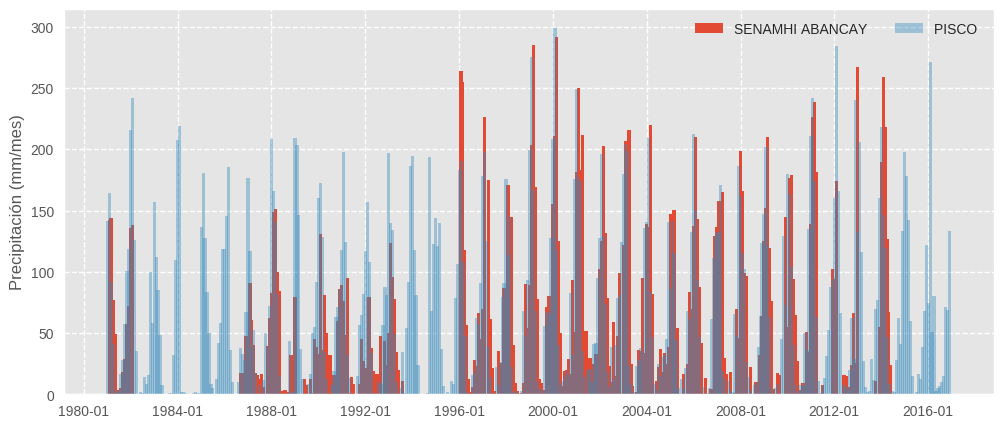

In [562]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,5), dpi=100)
ax.bar(df_station_monthly.index, df_station_monthly['PP'], width=50, label='SENAMHI '+station_name)
ax.bar(df_pisco.index, df_pisco['P'], width=50, alpha=.4, label='PISCO ')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_title('', fontdict=font)
ax.set_ylabel('Precipitación (mm/mes)')
ax.set_xlabel('')
ax.legend(loc='upper right',prop={'size': 10},ncol=3)
ax.grid(linestyle='--')

In [510]:
len(df_station_monthly)

402

In [519]:
b = np.ceil(np.linspace(0,len(df_station_monthly),30))

In [514]:
a = np.arange(0,len(df_station_monthly),12)

In [515]:
len(a)

34

In [517]:
len(dates_rng)

30

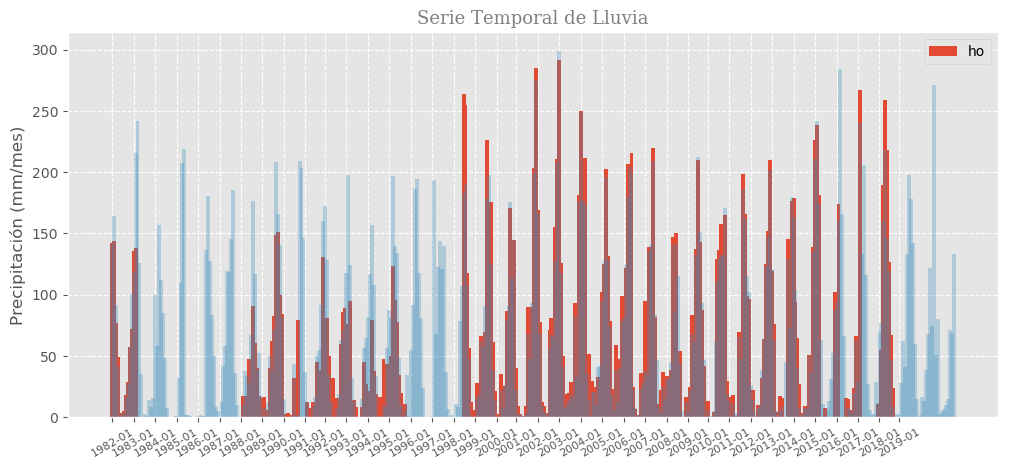

In [557]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,5), dpi=100)
ax.bar(range(len(df_station_monthly)), df_station_monthly['PP'], width=2.0, label='ho')
ax.bar(range(len(ds_point.P)), ds_point.P, alpha=.3, width=2.0)
dates_rng = pd.date_range('1982-01-01', '2019-02-01', freq='12M')
xi = [int(x) for x in np.ceil(np.linspace(0,len(df_station_monthly)+1,len(dates_rng)))]
plt.xticks(xi, [dtz.strftime('%Y-%m') for dtz in dates_rng], rotation=30, size=8)
ax.set_title('Serie Temporal de Lluvia', fontdict=font)
ax.set_ylabel('Precipitación (mm/mes)')
ax.set_xlabel('')
ax.legend(loc='upper right',prop={'size': 10},ncol=3)
ax.grid(linestyle='--')

In [525]:
len(dates_rng)

32

In [444]:
df_station_monthly

,PP
Date,
1981-01-31,607.8
1981-02-28,332.2
1981-03-31,380.4
1981-04-30,234.6
1981-05-31,30.8
1981-06-30,144.4
1981-07-31,106.0
1981-08-31,162.6
1981-09-30,85.2
